In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import cv2
from pathlib import Path
import sys


In [2]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
tumor = []
path = './data/brain_tumor_dataset/yes/*.jpg'
for i in glob.iglob(path):
    img = cv2.imread(i)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    tumor.append(img)


In [3]:
healthy = []
path = './data/brain_tumor_dataset/no/*.jpg'
for i in glob.iglob(path):
    img = cv2.imread(i)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    healthy.append(img)

In [4]:
healthy = np.array(healthy)
tumor = np.array(tumor)
ALL = np.concatenate((tumor, healthy))




In [5]:
tumor.shape, healthy.shape, ALL.shape

((154, 128, 128, 3), (91, 128, 128, 3), (245, 128, 128, 3))

In [6]:
def get_random_sample(arr, num):
    images = arr[np.random.choice(len(arr), num, replace = False)]
    return images

tumor_sample = get_random_sample(tumor, 5)
healthy_sample = get_random_sample(healthy, 5)

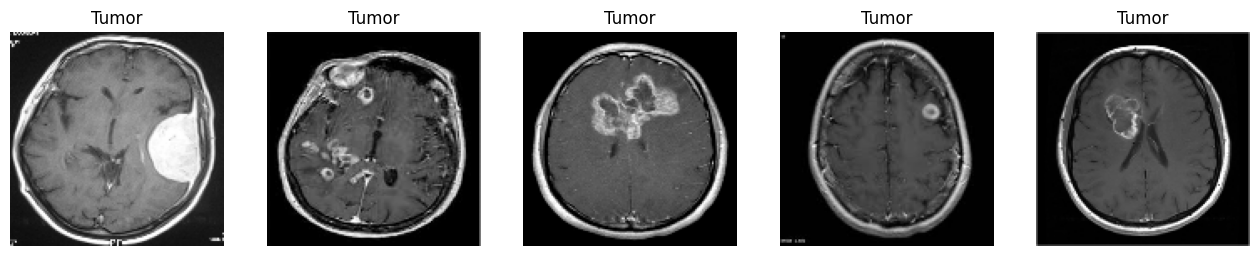

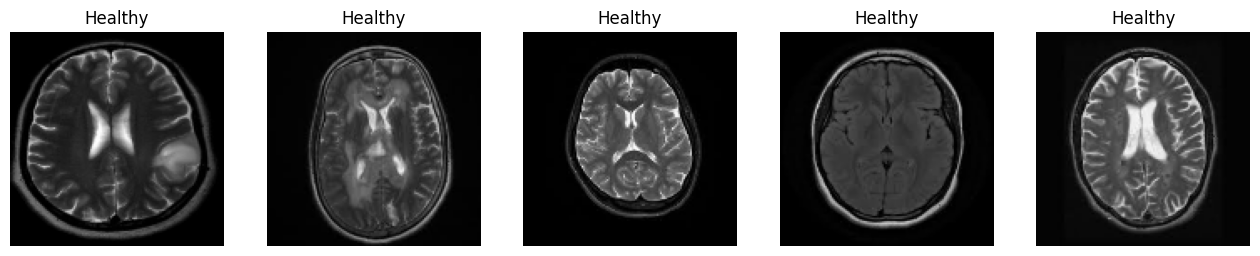

In [7]:
def plot_images(sample1, sample2, title1, title2):
    plt.figure(figsize=(16, 9))
    for i in range(len(sample1)):
        plt.subplot(1, len(sample1), i + 1)
        plt.imshow(sample1[i])
        plt.axis(False)
        plt.title(title1)

    plt.figure(figsize=(16, 9))
    for i in range(len(sample2)):
        plt.subplot(2, len(sample2), i + 1)
        plt.title(title2)
        plt.axis(False)
        plt.imshow(sample2[i])


plot_images(tumor_sample, healthy_sample, "Tumor", "Healthy")

In [8]:
class MRI(Dataset):
    def __init__(self):
        tumor = []
        healthy = []
        
        for  i in glob.iglob('./data/brain_tumor_dataset/yes/*.jpg'):
            img = cv2.imread(i)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
            tumor.append(img)
        
        for  i in glob.iglob('./data/brain_tumor_dataset/no/*.jpg'):
            img = cv2.imread(i)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
            healthy.append(img)

        tumor = np.array(tumor, dtype=np.float32)
        healthy = np.array(healthy, dtype=np.float32)

        tumor_sample = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_sample = np.zeros(healthy.shape[0], dtype = np.float32)

        self.images = np.concatenate((tumor, healthy), axis = 0)
        self.labels = np.concatenate((tumor_sample, healthy_sample), axis = 0)
         

    def __getitem__(self, index):
        sample = {'image': self.images[index], 'label': self.labels[index]}
        return sample
    
    def __len__(self):
        return self.images.shape[0]
    
    def normalize(self):
        self.images = self.images / 255.0
        
mri = MRI()
mri.normalize()



In [9]:
# class MRI(Dataset):
#     def __init__(self):
#         self.images = []
#         self.labels = []
#         data_path = Path("data/brain_tumor_dataset")
#         image_path_list = list(data_path.glob("*/*.jpg"))
#         for i in range(len(image_path_list)):
#             self.labels.append(image_path_list[i].parent.stem)
#             img = cv2.imread(image_path_list[i])
#             img = cv2.resize(img, (128, 128))
#             b, g, r = cv2.split(img)
#             img = cv2.merge([r, g, b])
#             img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
#             self.images.append(img)
#         self.images = np.array(self.images, dtype=np.float32)
         

#     def __getitem__(self, index):
#         sample = {'image': self.images[index], 'label': self.labels[index]}
#         return sample
    
#     def __len__(self):
#         return self.images.shape[0]
    
#     def normalize(self):
#         self.images = self.images / 255.0

#     def image_show(self, index):
#         plt.imshow(self.images[index].reshape(self.images[index].shape[2], self.images[index].shape[1], self.images[index].shape[0]))
#         plt.title(f"Tumor Situation: {self.labels[index]}")
#         plt.axis(False)
# mri = MRI()
# mri.normalize()


In [10]:
dataloader = DataLoader(mri, batch_size = 10, shuffle = True)

In [11]:
# for sample in dataloader:
#     img = sample['image'].squeeze(dim=1)
#     title = sample['label']
#     print(img.shape)

In [12]:
class ModelV0(nn.Module):
    def __init__(self):
        super(ModelV0, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=8,
                kernel_size=3
            ),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=8,
                out_channels=16,
                kernel_size=3
            ),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=14400,
                out_features=120
            ),
            nn.Tanh(),
            nn.Linear(
                in_features=120,
                out_features=84
            ),
            nn.Tanh(),
            nn.Linear(
                in_features=84,
                out_features=1
            )
        )
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        x = F.sigmoid(x)
        return x


In [13]:
model0 = ModelV0().to(device)


In [14]:
dataloader = DataLoader(mri, batch_size = 32)

In [15]:
model0.eval()
outputs = []
y_pure_pred = []
y_true = []
# with torch.no_grad():
with torch.inference_mode():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_pred = model0(image)

        y_pure_pred.append(y_pred.cpu().detach().numpy())
        outputs.append(y_pred.argmax(dim = 1).cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

In [16]:
outputs = np.concatenate(outputs, axis = 0).squeeze()
y_true = np.concatenate(y_true, axis = 0).squeeze()
y_pure_pred = np.concatenate(y_pure_pred).squeeze()


In [17]:
accuracy_score(y_true, outputs)

0.37142857142857144

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

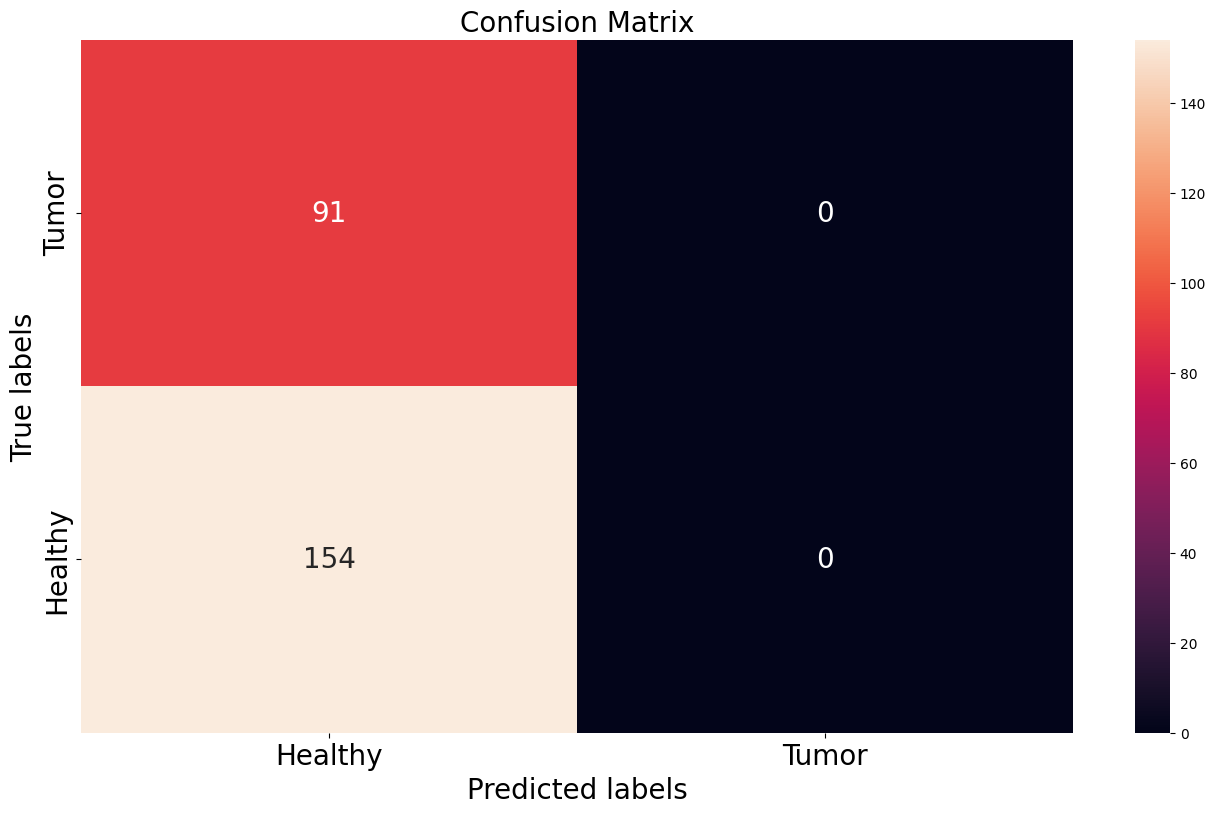

In [18]:
# a better confusion matrix
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, outputs)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

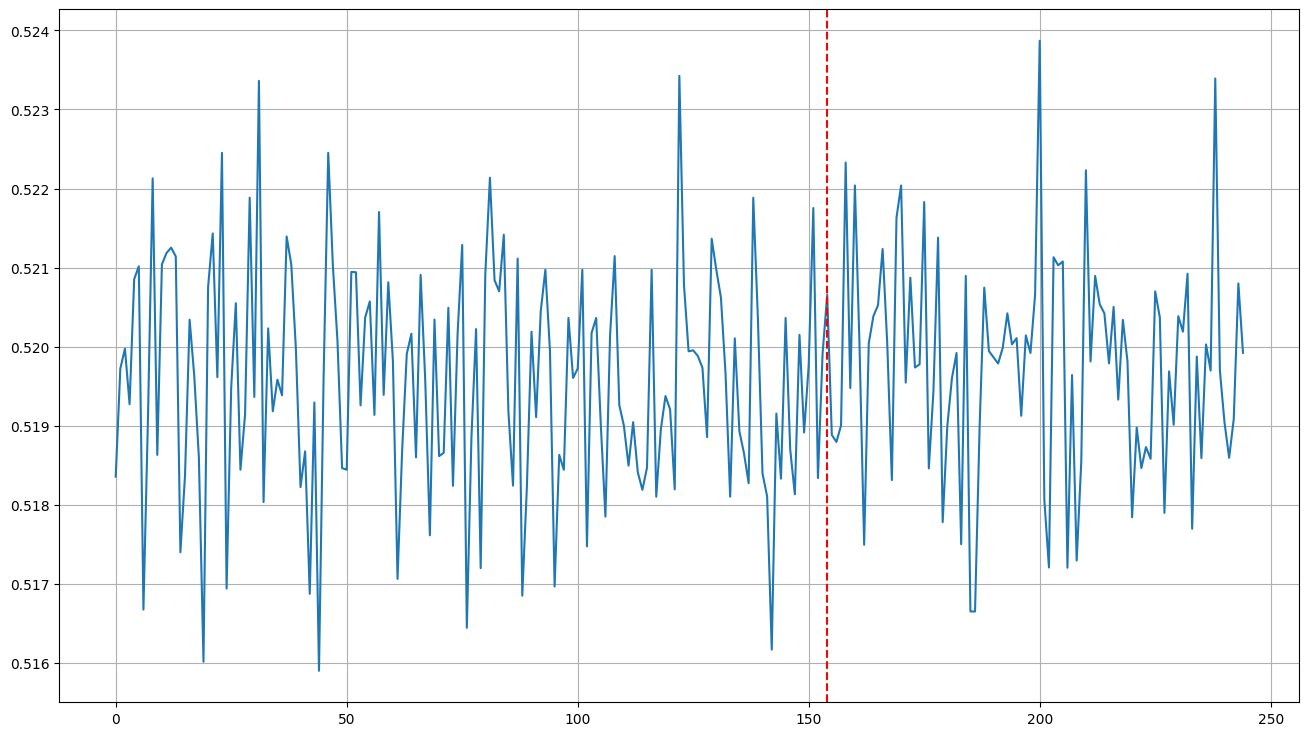

In [19]:
plt.figure(figsize=(16,9))
plt.plot(y_pure_pred)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()


In [20]:
EPOCHS = 100
optimizer = torch.optim.Adam(model0.parameters(), lr = 0.001)
dataloader = DataLoader(mri, batch_size=32, shuffle=True)

In [21]:
for i in range(1, EPOCHS):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        img = D['image'].to(device)
        label = D['label'].to(device)
        y_pred = model0(img).squeeze()
        loss_fn = nn.BCELoss()
        loss = torch.sum(loss_fn(y_pred, label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (i+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(i+1, np.mean(losses)))


Train Epoch: 10	Loss: 0.403040
Train Epoch: 20	Loss: 0.057191
Train Epoch: 30	Loss: 0.004572
Train Epoch: 40	Loss: 0.002076
Train Epoch: 50	Loss: 0.001284
Train Epoch: 60	Loss: 0.000887
Train Epoch: 70	Loss: 0.000659
Train Epoch: 80	Loss: 0.000525
Train Epoch: 90	Loss: 0.000420
Train Epoch: 100	Loss: 0.000346


In [22]:
dataloader = DataLoader(mri, batch_size=32, shuffle=False)
model0.eval()
outputs = []
y_pure_pred = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_pred = model0(image)
        predictions = (y_pred >= 0.5).float()

        outputs.append(predictions.cpu().numpy())
        y_pure_pred.append(y_pred.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate(outputs, axis = 0).squeeze()
y_true = np.concatenate(y_true, axis = 0).squeeze()
y_pure_pred = np.concatenate(y_pure_pred).squeeze()

In [23]:
accuracy_score(y_true, outputs)


1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

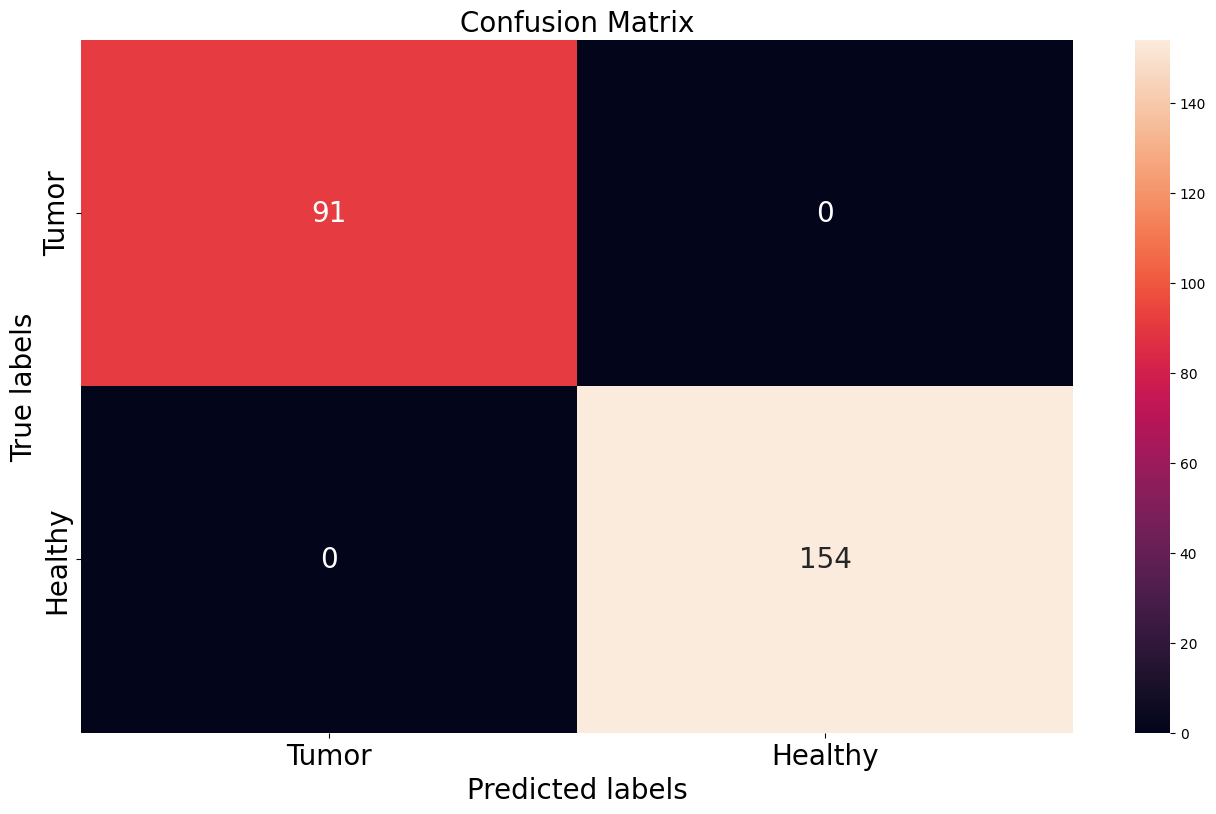

In [24]:
# a better confusion matrix
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, outputs)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

In [25]:
print(outputs)


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]


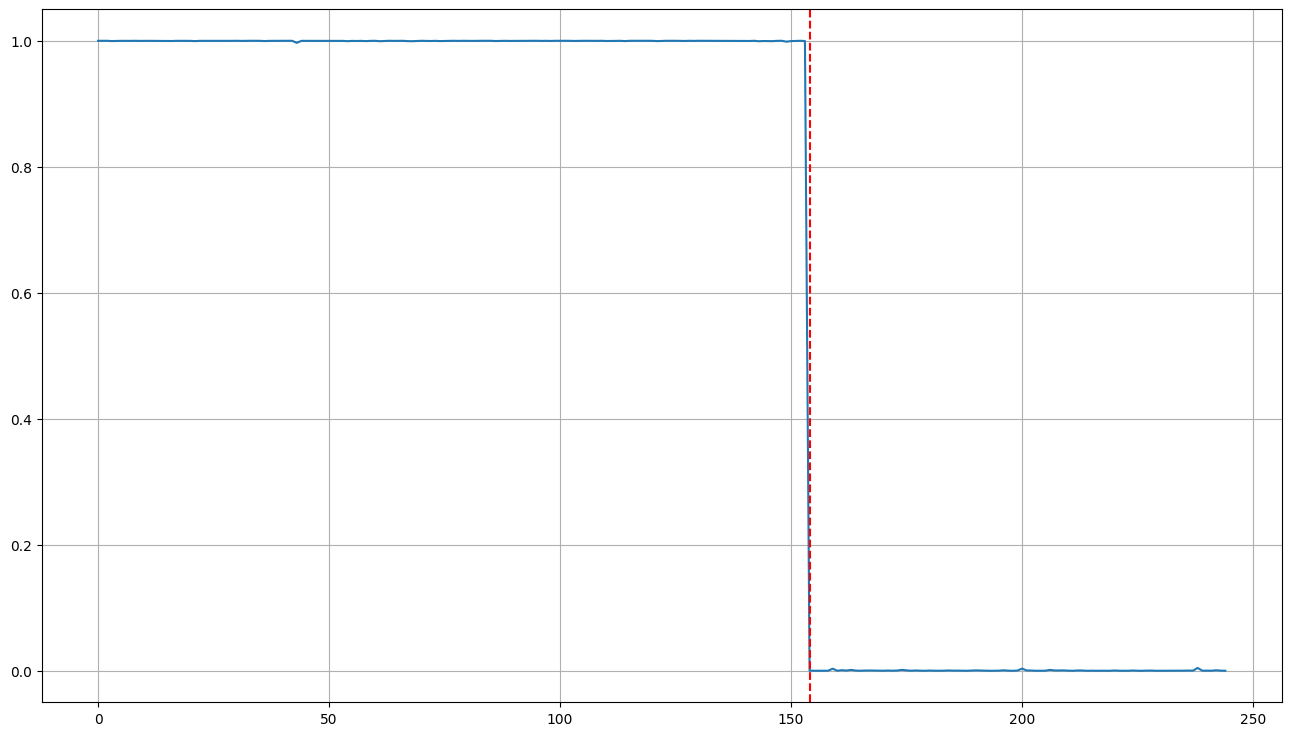

In [26]:
plt.figure(figsize=(16,9))
plt.plot(y_pure_pred)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()


In [27]:
num_layers = 0
conv_layers = []

In [28]:
model0_children = list(model0.children())

In [29]:
for child in model0.children():
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                conv_layers.append(layer)
                num_layers += 1
conv_layers, num_layers


([Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1)),
  Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))],
 2)

In [30]:
img = mri[100]['image']
img = torch.from_numpy(img).to(device).unsqueeze(dim=0)
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
results[0].shape


torch.Size([1, 8, 126, 126])

Layer  1


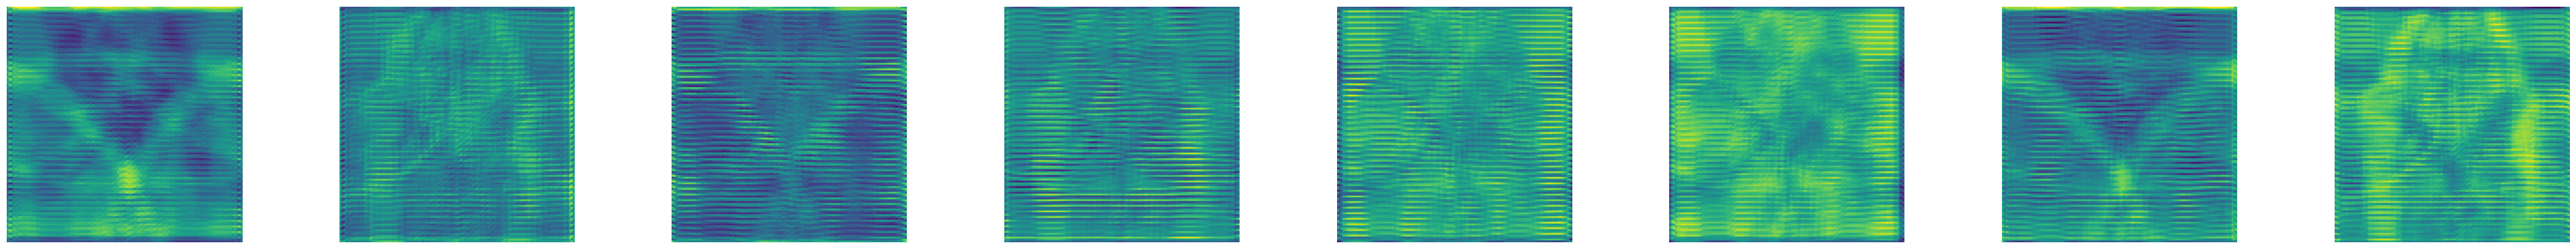

Layer  2


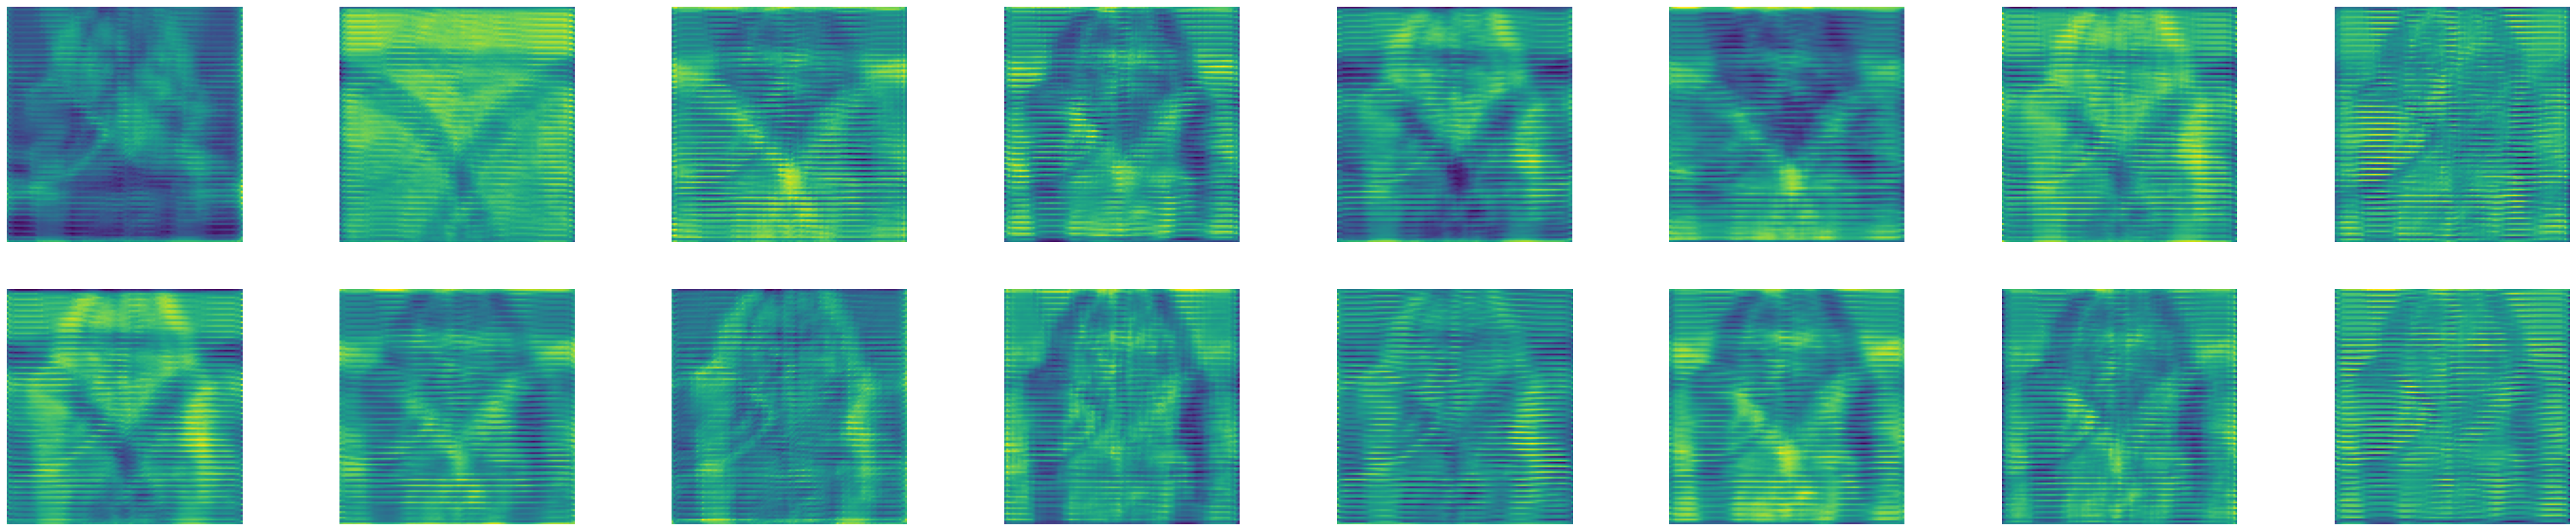

In [31]:
for num_layer in range(len(results)):
    plt.figure(figsize=(50, 10))
    layer_viz = results[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

In [32]:
class ModelV1(nn.Module):
    def __init__(self):
        super(ModelV1, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=2)
        )
        self.dropout = nn.Dropout(p=0.5)
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=5
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=26912,
                out_features=1
            )
        )
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.dropout(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        x = F.sigmoid(x)
        return x

In [33]:
from torchvision import transforms, datasets
from PIL import Image
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(10)
])

In [34]:
class MRI(Dataset):
    
    def __init__(self, transform = None):
        
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None
        self.transform = transform
        
        self.mode = 'train'
        
        tumor = []
        healthy = []

        for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            tumor.append(img)

        for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
    
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)
        
    def __len__(self):
        
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
    
    def __getitem__(self, idx):
        
        if self.mode== 'train':
            img = self.X_train[idx].reshape(128, 128, 3)
            img = Image.fromarray(img)
            img = self.transform(img)
            sample = {'image': img, 'label': self.y_train[idx]}
        
        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [35]:
mri_dataset = MRI(transform=train_transform)
mri_dataset.normalize()
mri_dataset.train_val_split()

model = ModelV1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.1)

In [36]:
mri_dataset.mode = "train"
mri_dataset[194]



TypeError: Cannot handle this data type: (1, 1, 3), <f4

In [ ]:
train_dataloader = DataLoader(mri_dataset, batch_size=18, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=18, shuffle=False)

In [ ]:
epoch_train_loss = []
epoch_val_loss = []
for epoch in range(1,150):
    train_losses = []
    # train for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    
    # validate for the current epoch
    val_losses = []
    model.eval()
    
    mri_dataset.mode = 'val'
    predictions = []
    with torch.no_grad():
        for D in val_dataloader:            
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))
    
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))
    

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


RuntimeError: Given groups=1, weight of size [16, 3, 3, 3], expected input[18, 128, 128, 3] to have 3 channels, but got 128 channels instead

In [ ]:
outputs = []
y_pure_pred = []
y_true = []
mri_dataset.mode = 'val'
dataloader = DataLoader(mri_dataset)
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_pred = model(image)
        predictions = (y_pred >= 0.5).float()

        outputs.append(predictions.cpu().numpy())
        y_pure_pred.append(y_pred.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate(outputs, axis = 0).squeeze()
y_true = np.concatenate(y_true, axis = 0).squeeze()
y_pure_pred = np.concatenate(y_pure_pred).squeeze()

Text(0, 0.5, 'Loss')

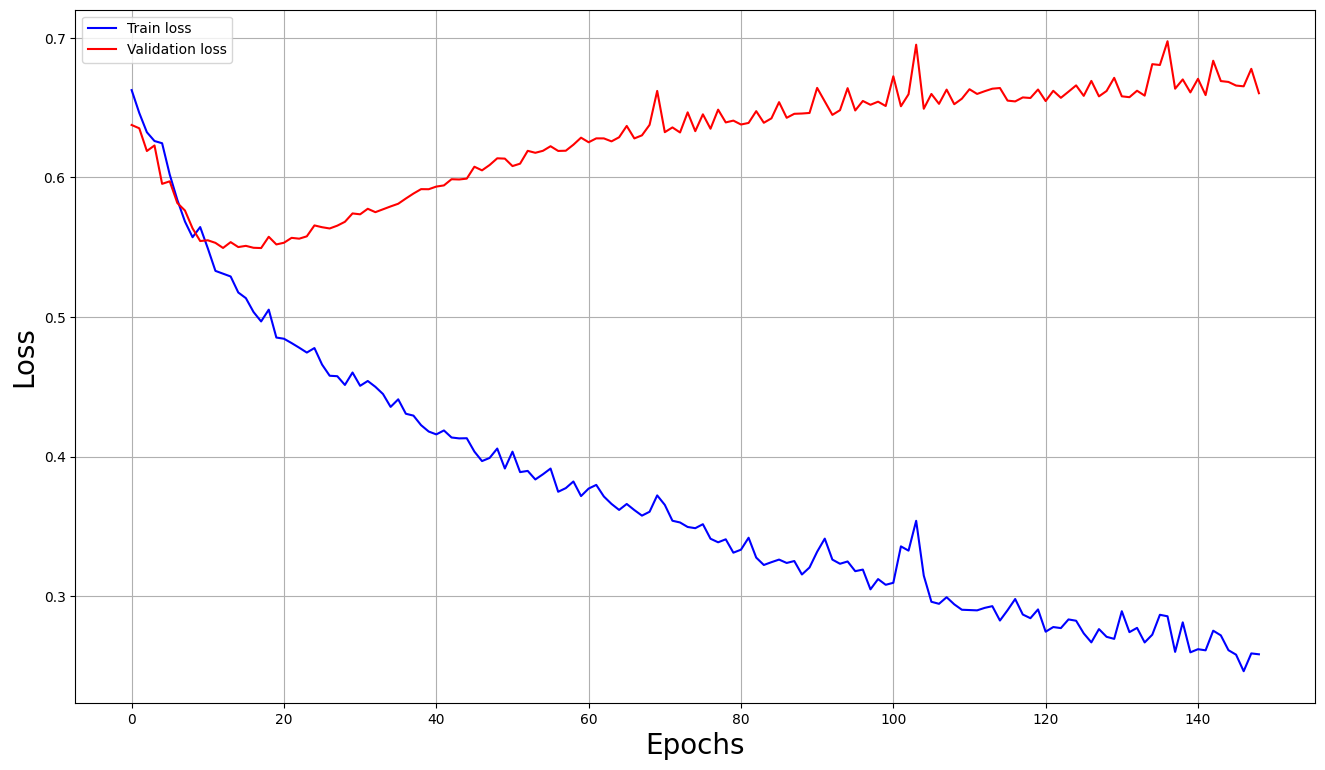

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)